<a href="https://colab.research.google.com/github/Polyakri/projects/blob/main/MachineLearningProjects/Feature_Selection_with_NN/Feature_selection_with_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Libraries and importing Dataset

In [1]:
##pip install ydata-profiling


In [2]:
import pandas as pd
import numpy as np
##from ydata_profiling import ProfileReport
import webbrowser
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.decomposition import PCA

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = 'drive/MyDrive/bankloan.csv'
df = pd.read_csv(file_path)


In [4]:
'''profile = ProfileReport (df, title = "Pandas Profiling Report")
profile'''

#These cannot be processes. Did it externally


'profile = ProfileReport (df, title = "Pandas Profiling Report")\nprofile'

#Data Preparation

With a first look we can see that we don't need id member id and row id

In [5]:
columns_to_drop = ['id','Row ID', 'member_id']
df.drop(columns=columns_to_drop, inplace=True)

We can use the describe method on loan_amnt column to see the mean, min and max amount the candidates apply for

In [6]:
df['loan_amnt'].describe()

count    212999.000000
mean      15257.965530
std        8611.713377
min        1000.000000
25%        8500.000000
50%       14000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Term should be changed to 0->36 months, 1 ->60 months

In [7]:
unique_values = df['term'].unique()
unique_values

array([' 36 months', ' 60 months'], dtype=object)

In [8]:
df['term'] = df['term'].replace({' 36 months': 0, ' 60 months': 1})
unique_values = df['term'].unique()
unique_values

array([0, 1])

Since the grade and the subgrade are actually the same, I decided to drop the grade and keep only the subgrade. I normalized in order A1->0 , A2-> 1 etc

In [9]:
dfn = df [['grade', 'sub_grade']]
dfn

,grade,sub_grade
0,C,C1
1,C,C2
2,B,B3
3,B,B4
4,E,E4
...,...,...
212994,C,C3
212995,B,B5
212996,E,E3
212997,D,D1


In [10]:
df.drop(columns='grade', inplace=True)
grade_mapping = {
    'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4,
    'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9,
    'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14,
    'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19,
    'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24,
    'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29,
    'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34
}


df['sub_grade'] = df['sub_grade'].replace(grade_mapping)
unique_values = sorted(df['sub_grade'].unique())
print(unique_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


The emp title has so many different job titles that will mess the algorithm. So it is best to drop it

In [11]:
df.drop(columns='emp_title', inplace=True)

emp length has nan values better to drop and also since the number of years play a significant role and is a continuous variable let's make it 0-10

In [12]:
df = df.dropna(subset=['emp_length'])
grade_mapping = {
   '< 1 year' : 0 , '1 year': 1 , '2 years' : 2 , '3 years' : 3 , '4 years' : 4 , '5 years' : 5 , '6 years' : 6 , '7 years' : 7 , '8 years' : 8  , '9 years' : 9, '10+ years' : 10
}

df['emp_length'] = df['emp_length'].replace(grade_mapping)
unique_values = sorted(df['emp_length'].unique())
print(unique_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


The home ownership takes distinct values so it is better to one hot encode it. Verification status, purpose, title as well. Title has missing values so drop them

In [13]:
df = pd.get_dummies(df, columns=['home_ownership'], prefix='home_ownership')
df =pd.get_dummies(df, columns=['verification_status'], prefix='vf_status')
df =pd.get_dummies(df, columns=['purpose'], prefix='purpose')

df = df.dropna(subset=['title'])
df =pd.get_dummies(df, columns=['title'], prefix='purpose')
df= pd.get_dummies(df, columns=['initial_list_status'], prefix='initial_list_status')
df= pd.get_dummies(df, columns=['application_type'], prefix='application_type')
df= pd.get_dummies(df, columns=['loan_status'], prefix='loan_status')

Issue_d ,earliest_cr_line, last_pymnt_d, next_pymnt_d have months, lets clear them and add a map for the months

In [14]:
def process_date_column(df, column_name):
    # Splitting the date column into day and month
    df['day'] = df[column_name].str.split('-').str[0]
    df['month'] = df[column_name].str.split('-').str[1]

    # Mapping months to numbers
    month_mapping = {
        'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'Jun': 5,
        'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11
    }

    df[column_name] = df['month'].map(month_mapping)

    # Drop the original date column, day, and month columns if needed
    df = df.drop(['day', 'month'], axis=1)

    return df

df = process_date_column (df, 'issue_d')
print ("Issue d")
unique_values = sorted(df['issue_d'].unique())
print(unique_values)

df = df.dropna(subset=['last_pymnt_d'])
df = process_date_column (df, 'last_pymnt_d')
print ("Last payment done")
unique_values =df['last_pymnt_d'].unique()
print(unique_values)


df = df.dropna(subset=['next_pymnt_d'])
df = process_date_column (df, 'next_pymnt_d')
print ("Next payment done")
unique_values = sorted(df['next_pymnt_d'].unique())
print(unique_values)

df = df.dropna(subset=['last_credit_pull_d'])
df = process_date_column (df, 'last_credit_pull_d')
print ("last_credit_pull_d")
unique_values =df['last_credit_pull_d'].unique()
print(unique_values)


Issue d
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Last payment done
[ 9  8 10  7  0 11  6  5  4  3  2  1]
Next payment done
[0, 1, 2]
last_credit_pull_d
[ 0 11 10  8  9  7  6  5]


Earliest cr line has many different values that might mess the model. Let's exclude this column

In [15]:
df.drop(columns='earliest_cr_line', inplace=True)

36 months, 60 months need to be dropped, already have that info

In [16]:
columns_to_drop = ['36months','60months']
df.drop(columns=columns_to_drop, inplace=True)

Lastly drop nan values from the whole dataset

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_info = pd.concat([df.dtypes, df.isna().sum()], axis=1)
data_info.columns = ['Data Type', 'NaN Count']

# Print the information side by side
print(data_info)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                                Data Type  NaN Count
loan_amnt                           int64          0
funded_amnt                         int64          0
term                                int64          0
int_rate                          float64          0
installment                       float64          0
sub_grade                           int64          0
emp_length                          int64          0
annual_inc                        float64          0
issue_d                             int64          0
dti                               float64          0
delinq_2yrs                         int64          0
inq_last_6mths                      int64          0
mths_since_last_delinq            float64      91704
open_acc                            int64          0
pub_rec                             int64          0
revol_bal                           int64          0
revol_util                        float64         76
total_acc                           int64     

We can see that the majority of the dataset has midding values at annual_inc_joint, dti_joint, unnamed: 50 and half the data are missing from mths_since_last_delinq. Let's drop it and drop the remaining nan values                       

In [18]:
columns_to_drop = ['mths_since_last_delinq', 'mths_since_last_major_derog', 'annual_inc_joint' , 'dti_joint', 'Unnamed: 50']
df.drop(columns=columns_to_drop, inplace=True)

df = df.dropna()

In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_info = pd.concat([df.dtypes, df.isna().sum()], axis=1)
data_info.columns = ['Data Type', 'NaN Count']

print (df.shape)
print("/-------------/")
# Print the information side by side
print(data_info)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

(189787, 73)
/-------------/
                                Data Type  NaN Count
loan_amnt                           int64          0
funded_amnt                         int64          0
term                                int64          0
int_rate                          float64          0
installment                       float64          0
sub_grade                           int64          0
emp_length                          int64          0
annual_inc                        float64          0
issue_d                             int64          0
dti                               float64          0
delinq_2yrs                         int64          0
inq_last_6mths                      int64          0
open_acc                            int64          0
pub_rec                             int64          0
revol_bal                           int64          0
revol_util                        float64          0
total_acc                           int64          0
out_prncp        

The dataset seems good. Let's proceed then

#Split tha dataset into targets and Features

Plot the target distribution

Text(0.5, 1.0, 'Histogram of Eligible Values')

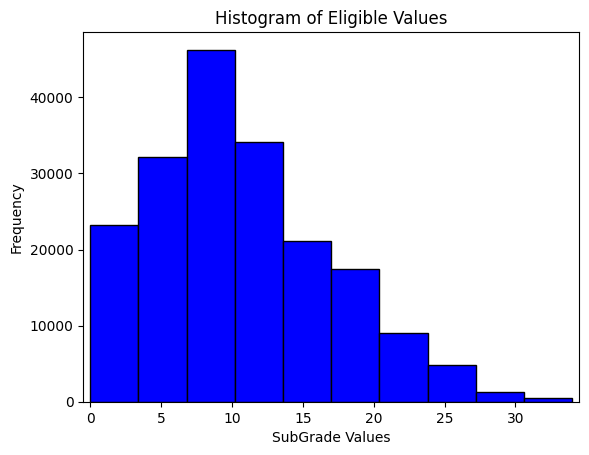

In [20]:
plt.plot(df['sub_grade'])
plt.hist(df['sub_grade'], bins=10, color='blue', edgecolor='black')
plt.xlim(-0.5, 34.5)
# Adding labels and title
plt.xlabel('SubGrade Values')
plt.ylabel('Frequency')
plt.title('Histogram of Eligible Values')

Create the eligible column by taking all the A grade and A1 and A2 subgrade

0    134439
1     55348
Name: Eligible, dtype: int64


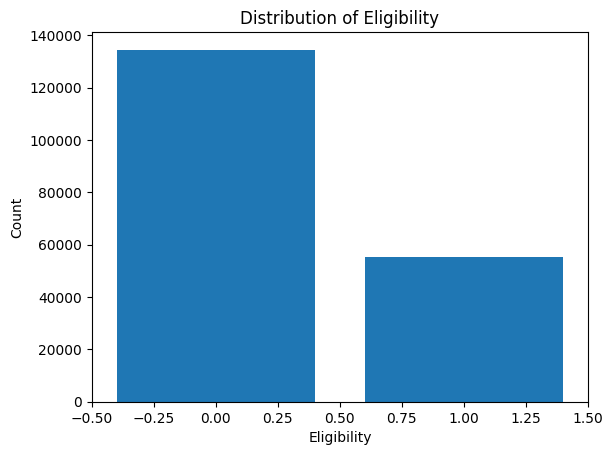

In [21]:
target_column = 'sub_grade'
df[target_column] = df[target_column].apply(lambda x: 1 if 0 <= x <= 6 else 0)
df.rename(columns={'sub_grade': 'Eligible'}, inplace=True)


value_counts = df['Eligible'].value_counts()
print (value_counts)

# Creating a bar plot
plt.bar(value_counts.index, value_counts.values)


plt.xlim(-0.5, 1.5)  # Adjusting x-axis limits for better visualization

# Adding labels and title
plt.xlabel('Eligibility')
plt.ylabel('Count')
plt.title('Distribution of Eligibility')

# Show the plot
plt.show()

Print the 3 max spaces that the possibility to be accepted for the loan is higher than 15%

In [22]:
loan_amount_counts = df.groupby('loan_amnt')['Eligible'].value_counts().unstack().fillna(0)
loan_amount_counts['Acceptance Rate'] = loan_amount_counts[1] / (loan_amount_counts[0] + loan_amount_counts[1]) * 100

array = loan_amount_counts['Acceptance Rate'].to_numpy ()
results = []
i=0

while i < len(array):
    if array[i] < 15:
        i += 1
        continue
    else:
        start = i
        j = i + 1

        while j < len(array) and array[j] >= 15:
            j += 1

        end = j - 1

        if start != end:
            results.append((start, end))

        i = j

sorted_results = sorted(results, key=lambda x: x[1] - x[0], reverse=True)



for i in range(min(3, len(sorted_results))):
    start, end = sorted_results[i]
    index_start = loan_amount_counts.index[start]
    index_end = loan_amount_counts.index[end]
    print(f"Range {i + 1}: {index_start} to {index_end}")

Range 1: 9350 to 9500
Range 2: 5800 to 5900
Range 3: 9900 to 10000


Make a plot

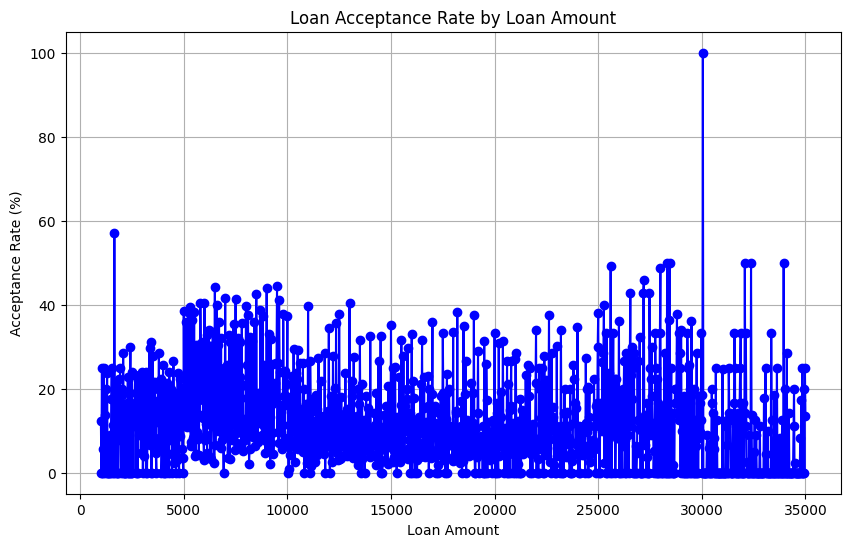

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(loan_amount_counts.index, loan_amount_counts['Acceptance Rate'], marker='o', linestyle='-', color='b')
plt.title('Loan Acceptance Rate by Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Acceptance Rate (%)')
plt.grid(True)
plt.show()

Split the dataset into target and features

In [24]:
target_column ='Eligible'
y = df[target_column].to_numpy()

# Drop the target column from the features
x = df.drop(columns=[target_column]).to_numpy()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify = y )


#Training the model

In this case I decided to use Neural Networks. The choice is because the dataset is big and complex and I believe that Neural Networks will have a good accuracy.

Creating the NN

In [25]:
num_classes = 2
y_test = tf.one_hot(y_test, depth=num_classes)
y_train = tf.one_hot(y_train, depth=num_classes)
y_train.shape, y_test.shape

(TensorShape([132850, 2]), TensorShape([56937, 2]))

I wanted to test many cases so I trained different NN with different parameters. I stored the results into a dataframe so if the session crashed for some reason, I won't have to retrain all these models.

In [26]:
input_shape = x_train.shape[1:]


results_file = 'drive/MyDrive/bankloan_res_with_nn.csv'

# Check if the results file exists, if not create it
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=['Learning Rate', 'Activation', 'Units per Layer', 'Hidden Layers', 'Accuracy', 'F1', 'Precision', 'Recall'])
else:
    results_df = pd.read_csv(results_file)

# Define a list of hyperparameters to iterate over
learning_rates = [0.001, 0.01, 0.1]
activations = ['relu', 'sigmoid', 'tanh']
units_per_layer_values = [32, 64, 128, 256]
num_hidden_layers_values = [1,2,3]
loss = 'binary_crossentropy'
metrics = ['accuracy']
batch_size = 32
epochs  =50

# Iterate over hyperparameter combinations
for learning_rate in learning_rates:
    for activation in activations:
        for units_per_layer in units_per_layer_values:
            for num_hidden_layers in num_hidden_layers_values:

                # Check if the combination already exists in the results file
                if results_df[
                    (results_df['Learning Rate'] == learning_rate) &
                    (results_df['Activation'] == activation) &
                    (results_df['Units per Layer'] == units_per_layer) &
                    (results_df['Hidden Layers'] == num_hidden_layers)
                ].empty:

                    # Build the model
                    model = tf.keras.Sequential(name='my_model')
                    model.add(tf.keras.layers.InputLayer(input_shape=input_shape, name='input_layer'))

                    for i in range(num_hidden_layers):
                        model.add(tf.keras.layers.Dense(units=units_per_layer, activation=activation, name=f'hidden_layer_{i+1}'))

                    model.add(tf.keras.layers.Dense(units=2, activation='sigmoid', name='output_layer'))

                    # Compile the model
                    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)

                    # Print model summary
                    print(f"\nTraining with learning rate={learning_rate}, activation={activation}, units_per_layer={units_per_layer}, num_hidden_layers={num_hidden_layers}")
                    model.summary()

                    # Train the model
                    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

                    # Evaluate the model on test data
                    y_pred = model.predict(x_test)
                    y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming a binary classification task

                    # Calculate metrics
                    accuracy = accuracy_score(y_test, y_pred_classes)
                    f1 = f1_score(y_test, y_pred_classes, average='weighted')  # Use 'weighted' for multilabel classification
                    precision = precision_score(y_test, y_pred_classes, average='weighted')
                    recall = recall_score(y_test, y_pred_classes, average='weighted')

                    # Save results to the file
                    results_df = results_df.append({
                        'Learning Rate': learning_rate,
                        'Activation': activation,
                        'Units per Layer': units_per_layer,
                        'Hidden Layers': num_hidden_layers,
                        'Accuracy': accuracy,
                        'F1': f1,
                        'Precision': precision,
                        'Recall': recall
                    }, ignore_index=True)
                    results_df.to_csv(results_file, index=False)

                    # Print metrics
                    print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

                else:
                    print(f"Skipping already processed combination: learning rate={learning_rate}, activation={activation}, units_per_layer={units_per_layer}, num_hidden_layers={num_hidden_layers}")

Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=32, num_hidden_layers=1
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=32, num_hidden_layers=2
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=32, num_hidden_layers=3
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=64, num_hidden_layers=1
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=64, num_hidden_layers=2
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=64, num_hidden_layers=3
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=128, num_hidden_layers=1
Skipping already processed combination: learning rate=0.001, activation=relu, units_per_layer=128, num_hidden_layers=2
Skipping already processed combination: learning rate=

In my opinion recall is the most important metric. We want to see how well the machine predicts the positives. From the candidates that the model predicts they are eligible to take the loan. how many of them are really going to pay it back.

Show 10 ranodm rows of the results df

In [27]:
results_df.sample(n=10)

,Hidden Layers,Units per Layer,Activation,Learning Rate,Accuracy,F1,Precision,Recall
9,1,64,relu,0.001,0.920157,0.918312,0.920198,0.920157
87,3,64,tanh,0.001,0.710891,0.596276,0.712618,0.710891
19,1,128,relu,0.010,0.708344,0.587427,0.501773,0.708344
96,3,128,tanh,0.001,0.709978,0.594998,0.706359,0.710592
4,1,32,sigmoid,0.010,0.708397,0.587518,0.793432,0.708397
84,3,64,sigmoid,0.001,0.709135,0.589889,0.724469,0.709135
100,3,256,relu,0.010,0.708362,0.587436,0.501777,0.708362
85,3,64,sigmoid,0.010,0.708362,0.587436,0.501777,0.708362
40,2,32,sigmoid,0.010,0.708362,0.587436,0.501777,0.708362
51,2,64,tanh,0.001,0.709064,0.591454,0.708406,0.709486


Find the highest recall

In [28]:
results_df_sorted_by_recall = results_df.sort_values(by='Recall', ascending=False)
results_df_sorted_by_recall.iloc[0]

Hidden Layers             1
Units per Layer         128
Activation             relu
Learning Rate         0.001
Accuracy           0.943657
F1                 0.943485
Precision          0.943417
Recall             0.943657
Name: 18, dtype: object

#Feature Importance and Selection

Train the random forest classifier

In [29]:
random_forest_classifier = RandomForestClassifier()

random_forest_classifier.fit(x_train, y_train)

y_pred = random_forest_classifier.predict(x_test)

In [30]:
accuracy1 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy1}")

precision1 = precision_score(y_test, y_pred, average='micro')
print(f"Precision: {precision1}")

recall1 = recall_score(y_test, y_pred, average='micro')
print(f"Recall: {recall1}")

f11 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f11}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.999929746913255
Precision: 0.999929746913255
Recall: 0.999929746913255
F1 Score: 0.999929746913255
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40332
           1       1.00      1.00      1.00     16605

   micro avg       1.00      1.00      1.00     56937
   macro avg       1.00      1.00      1.00     56937
weighted avg       1.00      1.00      1.00     56937
 samples avg       1.00      1.00      1.00     56937



In [31]:
feature_importances = random_forest_classifier.feature_importances_

columns_to_include = [col for col in df.columns if col != 'Eligible']

feature_importance_df = pd.DataFrame({'Feature': columns_to_include, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the most important features
print("Most Important Features:")
top_features = feature_importance_df.head(15)
top_features

Most Important Features:


,Feature,Importance
3,int_rate,0.694444
19,total_rec_int,0.053351
2,term,0.042112
18,total_rec_prncp,0.026364
31,total_rev_hi_lim,0.019367
17,total_pymnt,0.017204
4,installment,0.013119
14,revol_util,0.012075
24,last_pymnt_amnt,0.011806
36,vf_status_Not Verified,0.011799


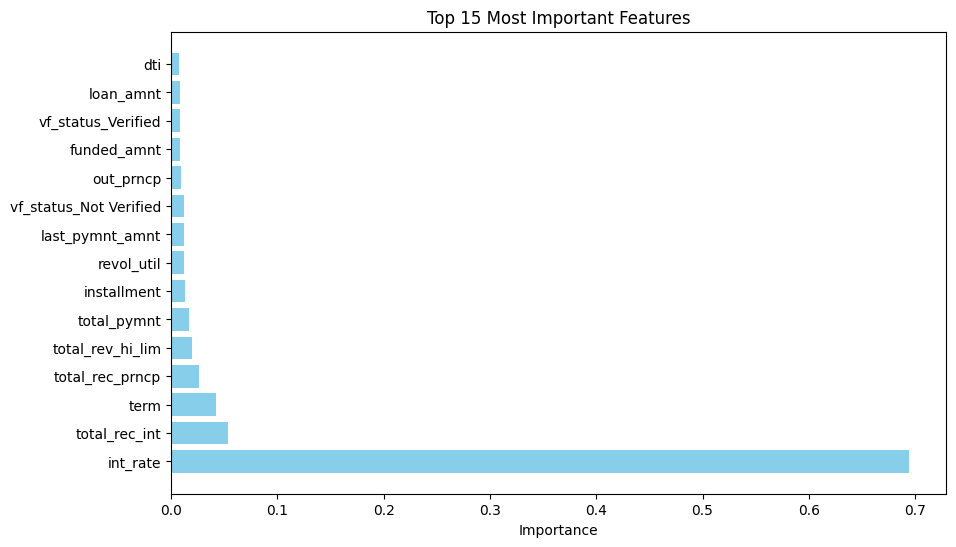

In [32]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.show()

Importance scores and rules extracted from Decision Trees and Random Forests can be valuable tools for the model user, but they should be used with caution in certain fields such as Risk Analysis, Medical Applications, etc. There are reasons why these results may not be easily accepted, and problems arise with rules and importance scores:



*   Complex Decisions:
Decision Trees and Random Forests can produce complex and intricate decision structures. The rules derived from these structures can be difficult for non-experts to comprehend, making the models challenging to interpret, especially when decisions are deep and complex.



*   Non-Interpretable Importance Scores:  Importance scores may not always correspond to intuitive or natural interpretations. While a feature may have a high importance score, its interpretation in terms of the actual content of the feature may be unclear.

*   Subjectivity: Sometimes, rules and importance scores can be subjective, depending on the selection of features and model parameters.



*   Data Sensitivity:Decision Trees are known for their sensitivity to small changes in training data. A small change in the data can lead to different rules or importance scores.
*   Generalization Issues: While a model may have high accuracy on the training data, the derived rules may not generalize well to new data. This can result in incorrect or unreliable decisions.

Print the corellation matrix

In [33]:
desired_columns = top_features['Feature'].tolist()

top_feature_df = df[desired_columns].copy()

correlation_matrix = top_feature_df.corr()

# Print the correlation matrix
print("Correlation Matrix for Top Features:")
correlation_matrix


Correlation Matrix for Top Features:


,int_rate,total_rec_int,term,total_rec_prncp,total_rev_hi_lim,total_pymnt,installment,revol_util,last_pymnt_amnt,vf_status_Not Verified,out_prncp,funded_amnt,vf_status_Verified,loan_amnt,dti
int_rate,1.000000,0.484546,0.457164,-0.111854,-0.190822,0.092383,0.119983,0.203597,0.073516,-0.247307,0.168570,0.147977,0.235094,0.147977,0.207186
total_rec_int,0.484546,1.000000,0.422215,0.445880,0.120276,0.717375,0.589226,0.157716,0.333498,-0.107006,0.611730,0.636604,0.088939,0.636604,0.092990
term,0.457164,0.422215,1.000000,-0.116566,0.063476,0.065625,0.112755,0.094301,0.063682,0.037305,0.427895,0.395145,-0.012821,0.395145,0.130589
total_rec_prncp,-0.111854,0.445880,-0.116566,1.000000,0.195998,0.943462,0.506902,0.020347,0.533306,-0.002868,0.330167,0.432480,-0.010318,0.432480,-0.051679
total_rev_hi_lim,-0.190822,0.120276,0.063476,0.195998,1.000000,0.197096,0.329713,-0.103567,0.188806,0.069587,0.351383,0.358592,-0.025373,0.358592,0.090357
total_pymnt,0.092383,0.717375,0.065625,0.943462,0.197096,1.000000,0.612747,0.074244,0.538606,-0.041859,0.483518,0.572364,0.024905,0.572364,-0.005787
installment,0.119983,0.589226,0.112755,0.506902,0.329713,0.612747,1.000000,0.125059,0.568313,-0.103670,0.923140,0.941177,0.073745,0.941177,0.011576
revol_util,0.203597,0.157716,0.094301,0.020347,-0.103567,0.074244,0.125059,1.000000,0.060324,-0.154046,0.129296,0.125897,0.123323,0.125897,0.170329
last_pymnt_amnt,0.073516,0.333498,0.063682,0.533306,0.188806,0.538606,0.568313,0.060324,1.000000,-0.061279,0.492819,0.533200,0.043474,0.533200,-0.003382
vf_status_Not Verified,-0.247307,-0.107006,0.037305,-0.002868,0.069587,-0.041859,-0.103670,-0.154046,-0.061279,1.000000,-0.064510,-0.061943,-0.396606,-0.061943,0.008704


And the corresponding heatmap

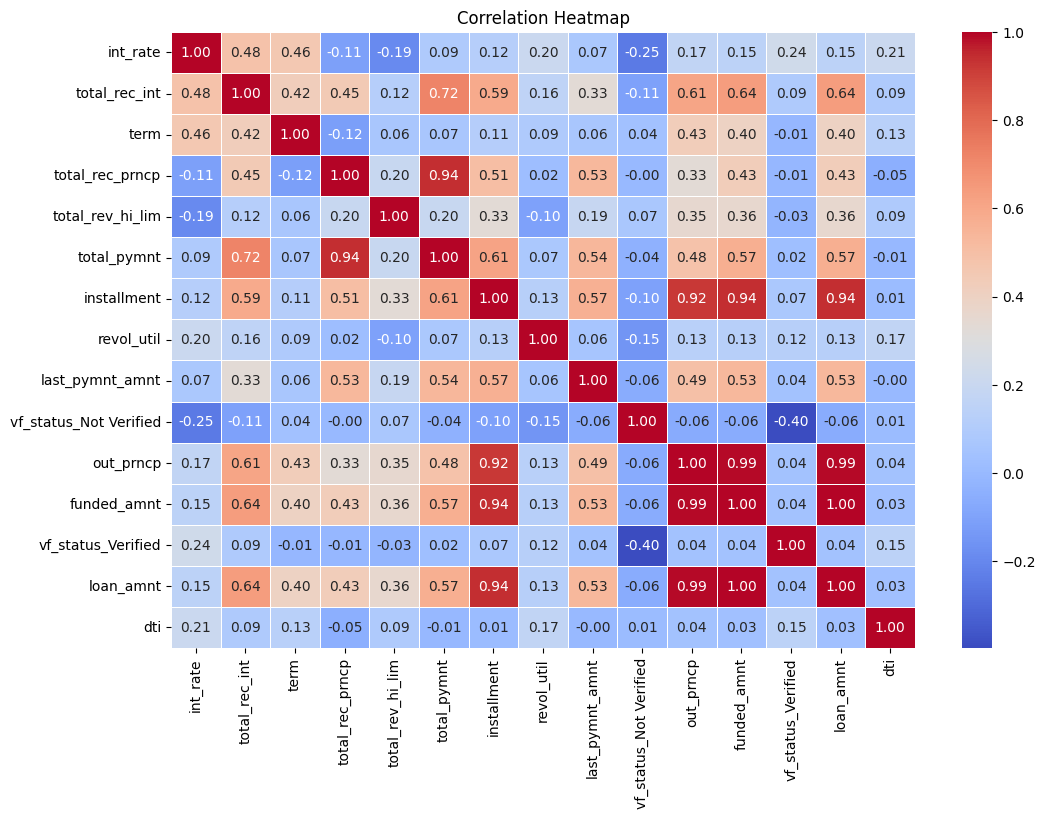

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

We can see there are some high correlated columns in the heatmap

We will take the 30 biggest importances and retrain the forest with only these

In [35]:
top_30 = feature_importance_df.head(30)
desired_columns = top_30['Feature'].tolist()

new_df = df[desired_columns].copy()

y = df['Eligible'].to_numpy()

x = new_df.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify = y )

random_forest_classifier = RandomForestClassifier()

random_forest_classifier.fit(x_train, y_train)

y_pred = random_forest_classifier.predict(x_test)

accuracy2 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy2}")

precision2 = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision2}")

recall2 = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall2}")

f12 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f12}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.999929746913255
Precision: 0.9999297638325366
Recall: 0.999929746913255
F1 Score: 0.9999297494016287
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40332
           1       1.00      1.00      1.00     16605

    accuracy                           1.00     56937
   macro avg       1.00      1.00      1.00     56937
weighted avg       1.00      1.00      1.00     56937



#Dimesnionality Reduction with PCA

In [36]:
target_column ='Eligible'
y = df[target_column].to_numpy()

# Drop the target column from the features
x = df.drop(columns=[target_column]).to_numpy()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify = y )

Find how many components are needed to keep 90% of the information

Number of components to retain 90% of the information: 2
Cumulative explained variance up to 2 components: 0.947718520562742


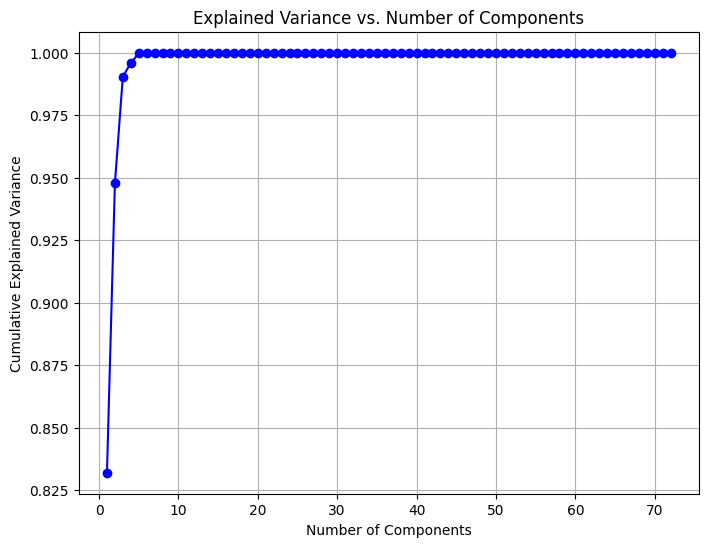

In [37]:
pca = PCA()
X_pca = pca.fit_transform(x_train)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.9) + 1

print("Number of components to retain 90% of the information:", n_components)
print("Cumulative explained variance up to", n_components, "components:", cumulative_variance[n_components - 1])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Keep only the 0.9 of the information

In [38]:
pca = PCA(n_components = n_components)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

random_forest_classifier = RandomForestClassifier()

random_forest_classifier.fit(x_train_pca, y_train)

y_pred = random_forest_classifier.predict(x_test_pca)

accuracy3 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy3}")

precision3 = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision3}")

recall3 = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall3}")

f13 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f13}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.6604668317614205
Precision: 0.6084438342842593
Recall: 0.6604668317614205
F1 Score: 0.622550422270457
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.78     40332
           1       0.34      0.18      0.24     16605

    accuracy                           0.66     56937
   macro avg       0.53      0.52      0.51     56937
weighted avg       0.61      0.66      0.62     56937



We can see that even if these 2 dimensions can keep the 90% of the information due to the variance, unfortunately it doesn't work well with the random forest

#LDA

Make some 2 indices for LDA

2    67220
0    67219
1    55348
Name: Eligible, dtype: int64


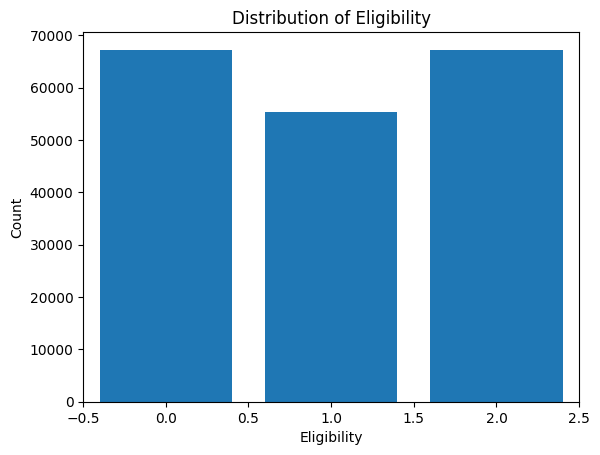

In [39]:
indices_to_replace = df[df['Eligible'] == 0].sample(frac=0.5).index

# Replace those indices with 2
df.loc[indices_to_replace, 'Eligible'] = 2


value_counts = df['Eligible'].value_counts()
print (value_counts)

# Creating a bar plot
plt.bar(value_counts.index, value_counts.values)


plt.xlim(-0.5, 2.5)  # Adjusting x-axis limits for better visualization

# Adding labels and title
plt.xlabel('Eligibility')
plt.ylabel('Count')
plt.title('Distribution of Eligibility')

# Show the plot
plt.show()

Perform LDA

In [40]:
target_column ='Eligible'
y = df[target_column].to_numpy()

# Drop the target column from the features
x = df.drop(columns=[target_column]).to_numpy()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(x, y)


Replace the 2 indices with the original ones

0    134439
1     55348
dtype: int64


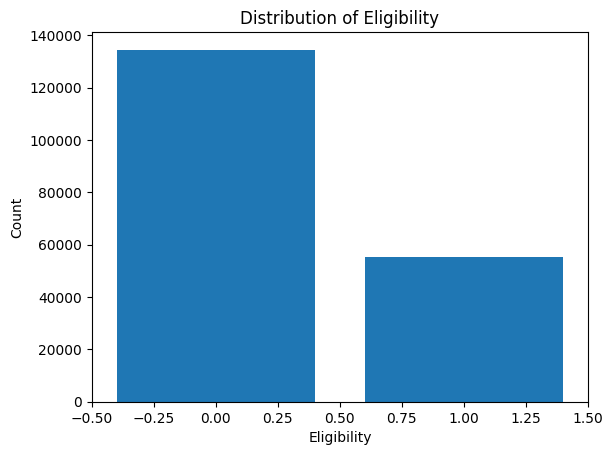

In [46]:
mask = (y == 2)

# Set the elements where the mask is True to 0
y[mask] = 0

value_counts = pd.Series(y).value_counts()
print (value_counts)

# Creating a bar plot
plt.bar(value_counts.index, value_counts.values)


plt.xlim(-0.5, 1.5)  # Adjusting x-axis limits for better visualization

# Adding labels and title
plt.xlabel('Eligibility')
plt.ylabel('Count')
plt.title('Distribution of Eligibility')

# Show the plot
plt.show()



# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.3, random_state=0, stratify = y )



Plot the x_train and x_test in 2d

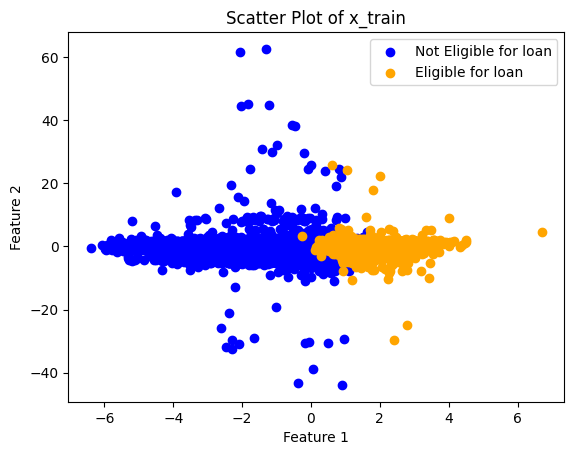

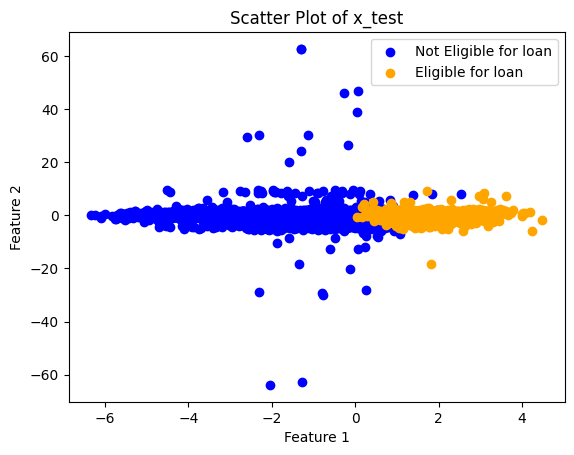

In [47]:
x_train_class_0 = x_train[y_train == 0]
x_train_class_1 = x_train[y_train == 1]

# Plotting
plt.scatter(x_train_class_0[:, 0], x_train_class_0[:, 1], c='blue', label='Not Eligible for loan')
plt.scatter(x_train_class_1[:, 0], x_train_class_1[:, 1], c='orange', label='Eligible for loan')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Scatter Plot of x_train')

# Show the plot
plt.show()

x_test_class_0 = x_test[y_test == 0]
x_test_class_1 = x_test[y_test == 1]

# Plotting
plt.scatter(x_test_class_0[:, 0], x_test_class_0[:, 1], c='blue', label='Not Eligible for loan')
plt.scatter(x_test_class_1[:, 0], x_test_class_1[:, 1], c='orange', label='Eligible for loan')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Scatter Plot of x_test')

# Show the plot
plt.show()


Predict with LDA

In [43]:
target_column ='Eligible'
y = df[target_column].to_numpy()

# Drop the target column from the features
x = df.drop(columns=[target_column]).to_numpy()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify = y )

y_pred = lda.predict(x_test)

mask = (y_test == 2)
mask = (y_pred==2)

# Set the elements where the mask is True to 0
y_test[mask] = 0
y_pred[mask] = 0

accuracy4 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy4}")

precision4 = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision4}")

recall4 = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall4}")

f14 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f14}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9278500799128861
Precision: 0.9417637962587624
Recall: 0.9278500799128861
F1 Score: 0.929862532247057
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     40348
           1       0.80      1.00      0.89     16589

    accuracy                           0.93     56937
   macro avg       0.90      0.95      0.92     56937
weighted avg       0.94      0.93      0.93     56937

